In [1]:
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2

Using TensorFlow backend.


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, Add
from tensorflow.keras.layers import LeakyReLU, ReLU

In [3]:
MODEL_DIR = "../assets/model/"
DATA_DIR = "../assets/data/"
LABELS_FILE = os.path.join(DATA_DIR, "labels.txt")
IMAGES_DIR = os.path.join(DATA_DIR, "samples")

(455, 320, 3)


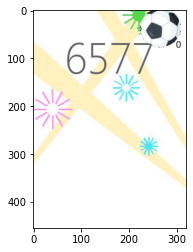

In [4]:
im = cv2.imread(os.path.join(IMAGES_DIR, "sample_0.JPEG"))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(im.shape)
plt.imshow(im)

SRC_HEIGHT, SRC_WIDTH, SRC_DEPTH = im.shape

In [5]:
image_gen = ImageDataGenerator(validation_split=0.15, rescale=1.0/255.0)
dataframe = pd.read_csv(LABELS_FILE, delim_whitespace=True)

ZOOM_FACTOR = 4
TARGET_SIZE = (SRC_HEIGHT//ZOOM_FACTOR, SRC_WIDTH//ZOOM_FACTOR)
print(f"target_size = {TARGET_SIZE}")
OUTPUT_SHAPE = 3

BATCH_SIZE = 64

#TARGET_COLUMNS = ["x_centre", "y_centre", "width", "height", "confidence"]
TARGET_COLUMNS = ["x_centre", "y_centre", "confidence"]

training_generator = image_gen.flow_from_dataframe(
    dataframe=dataframe,
    directory=IMAGES_DIR,
    x_col="filename",
    y_col=TARGET_COLUMNS,
    subset="training",
    shuffle=True,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    target_size=TARGET_SIZE)

validation_generator = image_gen.flow_from_dataframe(
    dataframe=dataframe,
    directory=IMAGES_DIR,
    x_col="filename",
    y_col=TARGET_COLUMNS,
    subset="validation",
    shuffle=True,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    target_size=TARGET_SIZE)

target_size = (113, 80)
Found 170000 validated image filenames.
Found 30000 validated image filenames.


In [6]:
batch = training_generator.next()

[0.2671875  0.05384615 1.        ]


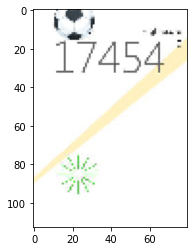

In [7]:
i = 12
X, y = batch[0][i], batch[1][i]
print(y)
plt.imshow(X)

In [8]:
def detect_accuracy(y_true, y_pred, thresh=0.8):
    true_cls = y_true[:,2]
    pred_cls = y_pred[:,2]
    pred_cls = tf.math.greater(pred_cls, thresh)
    pred_cls = tf.cast(pred_cls, true_cls.dtype)
    
    abs_err = tf.math.abs(true_cls-pred_cls)
    return 1-tf.math.reduce_mean(abs_err)

def position_accuracy(y_true, y_pred):
    true_cls = y_true[:,2]
    true_pos = y_true[:,:2]
    pred_pos = y_pred[:,:2]
    
    abs_err = tf.math.abs(true_pos-pred_pos)
    dist_sqr_err = tf.math.reduce_sum(tf.math.square(abs_err), axis=1)
    dist_err = tf.math.sqrt(dist_sqr_err)
    
    # only consider when object is there
    dist_err = tf.math.multiply(dist_err, true_cls)
    net_err = tf.math.reduce_sum(dist_err)
    total_objects = tf.math.reduce_sum(true_cls)
    
    mean_err = net_err / total_objects
    return 1-mean_err

In [11]:
def create_model(large=False):
    alpha = 0.2
    dropout = 0.1

    inputs = Input(shape=TARGET_SIZE+(3,))

#    x_skip = inputs
    
    x = Conv2D(16, (3, 3))(inputs)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = SeparableConv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = SeparableConv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3))(x)
    
#     x_skip = Conv2D(64, (16, 16))(x_skip)
#     x_skip = MaxPooling2D((17,17))(x_skip)
#     x = Add()([x, x_skip])

    # larger network
    if large:
        x = Conv2D(64, (3, 3))(x)
        x = ReLU()(x)
        x = MaxPooling2D((2, 2))(x)

        x = SeparableConv2D(128, (3, 3), padding="same")(x)
        x = ReLU()(x)
        x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)

    if large:
        x = Dense(128)(x)
        x = ReLU()(x)
    
    x = Dense(64)(x)
    x = ReLU()(x)

    x = Dense(32)(x)
    x = ReLU()(x)

    x = Dense(OUTPUT_SHAPE)(x)
    outputs = x
    #outputs = LeakyReLU(alpha)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss="mae",
    metrics=[detect_accuracy, position_accuracy, "accuracy"],
)

model.load_weights("../models/cnn_113_80.h5f")

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 113, 80, 3)]      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 78, 16)       448       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 111, 78, 16)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 55, 39, 16)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 53, 37, 32)        688       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 53, 37, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 18, 32)        0   

In [12]:
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

print("steps per epoch: {0}".format(steps_per_epoch))
print("validation steps {0}".format(validation_steps))

TOTAL_EPOCHS = 10

model.fit_generator(
    generator=training_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=TOTAL_EPOCHS,
)

steps per epoch: 2656
validation steps 468
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2656 steps, validate for 468 steps
Epoch 1/10
2656/2656 [==============================] - 379s 143ms/step - loss: 0.0169 - detect_accuracy: 0.9859 - position_accuracy: 0.9515 - accuracy: 0.6426 - val_loss: 0.0169 - val_detect_accuracy: 0.9861 - val_position_accuracy: 0.9518 - val_accuracy: 0.5109
Epoch 2/10
2656/2656 [==============================] - 375s 141ms/step - loss: 0.0159 - detect_accuracy: 0.9865 - position_accuracy: 0.9541 - accuracy: 0.6383 - val_loss: 0.0159 - val_detect_accuracy: 0.9862 - val_position_accuracy: 0.9532 - val_accuracy: 0.7325
Epoch 3/10
2656/2656 [==============================] - 374s 141ms/step - loss: 0.0153 - detect_accuracy: 0.9871 - position_accuracy: 0.9562 - accuracy: 0.6488 - val_loss: 0.0158 - val_detect_accuracy: 0.9858 - val_position_accuracy: 0.9527 - val_accuracy: 0

KeyboardInterrupt: 

In [13]:
# model.save_weights("../models/cnn_227_160.h5f")
model.save_weights("../models/cnn_113_80.h5f")

In [14]:
batch = validation_generator.next()
pred = model.predict(batch[0])

In [15]:
print(batch[1][:10])
print(pred[:10])

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.5609375  0.93076923 1.        ]
 [0.         0.         0.        ]]
[[ 1.2183487e-03 -4.0923059e-04 -2.0242110e-04]
 [ 8.9455396e-04 -2.7689710e-04 -1.1481717e-04]
 [ 9.1534667e-04 -2.7151406e-04 -5.3443015e-05]
 [ 8.8168867e-04 -1.9399822e-04  2.4843961e-05]
 [ 1.0800380e-03 -1.4106743e-04 -7.2136521e-05]
 [ 8.5132755e-04  1.6286969e-04 -4.5806542e-04]
 [ 9.0879761e-04 -2.7287938e-04 -9.0166926e-05]
 [ 1.1930019e-03  3.5829842e-04  3.3715367e-04]
 [ 5.6816453e-01  9.6488005e-01  1.0061092e+00]
 [ 8.1169233e-04  9.7726844e-04 -2.2333637e-03]]
